# Sentiment Analysis with RNN and BERT Embeddings

##Importing Libraries
Here, we import the nltk library, which is a leading platform for building Python programs to work with human language data. We download several key components:

- Stopwords: Commonly used words that are often removed during text processing.
- WordNet: A large lexical database of English.
- Punkt: A pre-trained tokenizer that helps in splitting text into words.

We also import the torch library for building and training neural networks. The torchvision module is used for handling image data and transformations. The transformers library from Hugging Face provides easy access to pre-trained models like BERT.

At the end, we import various utilities for file handling (os), regular expressions (re), making HTTP requests (requests), numerical operations (numpy), and plotting (matplotlib). We also use scikit-learn for splitting the data into training and testing sets.


In [ ]:
# Importing necessary libraries for deep learning, data manipulation, and model training

# nlp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel

# others
import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install transformers

##Load IMDB dataset
This section focuses on downloading and preparing the IMDB movie reviews dataset for sentiment analysis. This function downloads positive and negative movie reviews, combines them into a single list, and labels them accordingly (1 for positive and 0 for negative).



In [ ]:
# Load IMDB dataset

def download_imdb_data():
    pos_url = 'https://raw.githubusercontent.com/dennybritz/cnn-text-classification-tf/master/data/rt-polaritydata/rt-polarity.pos'
    neg_url = 'https://raw.githubusercontent.com/dennybritz/cnn-text-classification-tf/master/data/rt-polaritydata/rt-polarity.neg'
    pos_reviews = requests.get(pos_url).text.split('\n')
    neg_reviews = requests.get(neg_url).text.split('\n')
    reviews = pos_reviews + neg_reviews
    labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)
    return reviews, labels

reviews, labels = download_imdb_data()
print(f'Review: {reviews[0]},\n Label: {labels[0]}')

Review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . ,
 Label: 1


##Word Cloud
A word cloud visualizes the most frequent words in the dataset. It provides an intuitive way to quickly grasp the most prominent themes or topics present in the data.

##How Word Clouds Work?
Word clouds visually represent words that appear more frequently in the text as larger and bolder, while less frequent words appear smaller. This representation allows for easy identification of key terms and themes within the dataset.

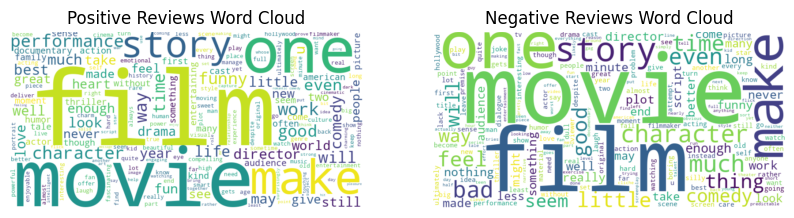

In [ ]:
from wordcloud import WordCloud

positive_text = ' '.join([review for review, label in zip(reviews, labels) if label == 1])
negative_text = ' '.join([review for review, label in zip(reviews, labels) if label == 0])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

## Cleaning Text Data
This function converts text to lowercase, removes non-alphabetic characters, tokenizes the text, removes stopwords, filters short words, and then joins the words back into a cleaned sentence.



In [ ]:
stop_words = stopwords.words('english')

def clean_text(sentence):
  sentence = str(sentence).lower()
  sentence = re.sub('[^a-z]',' ',sentence)
  sentence = word_tokenize(sentence)
  sentence = [i for i in sentence if i not in stop_words]
  sentence = [i for i in sentence if len(i)>2]
  sentence = ' '.join(sentence)
  return sentence

##Train Test Split
This code splits the dataset into training and validation sets (80/20 split) and then applies the text cleaning function to each review.



In [ ]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Apply clean text on the reviews
for txt in X_train:
  txt = clean_text(txt)

for txt in X_val:
  txt = clean_text(txt)

##Tokenization  
Here, we initialize a BERT tokenizer and model to get its embedding vectors as input of LSTM.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embedder = BertModel.from_pretrained('bert-base-uncased')
embedder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

##Dataset Preparation
We define a custom dataset class, MyDataset, that will handle the tokenized text and labels for both the training and validation datasets.


In [ ]:
class MyDataset(Dataset):
  def __init__(self, encoded, label):
    self.input_ids = encoded['input_ids']
    self.attention_mask = encoded['attention_mask']
    self.label = label

  def __getitem__(self, index):
    ids = self.input_ids[index]
    masks = self.attention_mask[index]
    lbls = self.label[index]
    return ids, masks, lbls

  def __len__(self):
    return len(self.input_ids)

##Creating DataLoaders
This section tokenizes the training and validation datasets, creating DataLoader objects for efficient batching and iteration during training.



In [ ]:
# Make Train dataset
train_encoded = tokenizer(X_train, padding=True, truncation=True, max_length=100, return_tensors='pt')
trainset = MyDataset(train_encoded, y_train)
train_loader = DataLoader(trainset, batch_size=16)

# Make validation dataset
val_encoded = tokenizer(X_val, padding=True, truncation=True, max_length=100, return_tensors='pt')
valset = MyDataset(val_encoded, y_val)
val_loader = DataLoader(valset, batch_size=16)

##Model Definition
This class defines a sentiment classifier using BERT for embedding, an LSTM layer for sequence modeling, and a fully connected layer for classification. The model outputs a probability score between 0 and 1.



In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedder, hidden_dim, output_dim, drop_prob=0.3):
        super(SentimentClassifier, self).__init__()
        self.bert = embedder
        self.lstm = nn.LSTM(embedder.config.hidden_size, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state
        lstm, (h_n, c_n) = self.lstm(bert_embeddings)
        drop = self.dropout(lstm[:, -1, :])
        out = self.fc(drop)
        return self.sigmoid(out)

model = SentimentClassifier(embedder, hidden_dim=16, output_dim=1)

##Loss Function, Optimizer, and Scheduler

- nn.BCELoss(): This is a binary cross-entropy loss function, which is used for binary classification problems. It measures the difference between the predicted probability and the actual class label, penalizing incorrect predictions. The loss function is moved to the selected device (GPU or CPU).

- optim.Adam(): This is an implementation of the Adam optimizer, which combines the advantages of two other popular optimizers: AdaGrad and RMSProp. It adjusts the learning rate for each parameter individually and performs well on a wide range of tasks. Here, the learning rate is set to 27e-6, and a weight decay (L2 regularization) of 1e-8 is applied to prevent overfitting by penalizing large weights.

- StepLR():
This scheduler adjusts the learning rate of the optimizer at fixed intervals (every step_size epochs). In this case, the learning rate is reduced by a factor of gamma (0.1) every 10 epochs. This helps in fine-tuning the model and can lead to better convergence by reducing the learning rate as training progresses.

In [ ]:
# Transport model to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Loss functiona, Optimizer and Scheduler
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-8)
scheduler = StepLR(optimizer, step_size=5, gamma=0.01)

##Model Training and Evaluation
This code initializes the model and sets up the training loop. It trains the model for a specified number of epochs, monitoring validation loss to save the best model and apply early stopping if the validation loss does not improve over a set number of epochs. At the end, we load the best model.



In [ ]:
num_epochs = 20
patience = 3  # Number of epochs to wait before stop trainig
best_val_loss = float('inf')
best_epoch = 0

# Directory to save the best model
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Lists to store loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train phase
    model.train()
    epoch_train_loss = 0

    for train_input_ids, train_attention_mask, train_labels in train_loader:
        train_input_ids = train_input_ids.to(device)
        train_attention_mask = train_attention_mask.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        outputs = torch.flatten(model(train_input_ids, train_attention_mask))
        loss = criterion(outputs, train_labels.float())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    scheduler.step()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for val_input_ids, val_attention_mask, val_labels in val_loader:
            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)
            val_outputs = torch.flatten(model(val_input_ids, val_attention_mask))
            loss = criterion(val_outputs, val_labels.float())
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    # Check if the validation loss improved for Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        print(f'Best model saved at epoch {epoch + 1}')

    # Check early stopping condition
    if epoch - best_epoch > patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

Epoch [1/20], Training Loss: 0.5095, Validation Loss: 0.4168
Best model saved at epoch 1
Epoch [2/20], Training Loss: 0.3708, Validation Loss: 0.4012
Best model saved at epoch 2
Epoch [3/20], Training Loss: 0.3120, Validation Loss: 0.3976
Best model saved at epoch 3
Epoch [4/20], Training Loss: 0.2660, Validation Loss: 0.3922
Best model saved at epoch 4
Epoch [5/20], Training Loss: 0.2427, Validation Loss: 0.4438
Epoch [6/20], Training Loss: 0.2391, Validation Loss: 0.4011
Epoch [7/20], Training Loss: 0.2210, Validation Loss: 0.3937
Epoch [8/20], Training Loss: 0.2147, Validation Loss: 0.3926
Early stopping at epoch 8


In [ ]:
# Load the best model
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
print('Best model loaded.')

Best model loaded.


##Making Predictions with the Best Model
Finally, this section uses the loaded best model and evaluates its performance on the validation set, calculating the accuracy of predictions.



In [ ]:
# Prediction phase
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_labels in val_loader:
        test_input_ids = test_input_ids.to(device)
        test_attention_mask = test_attention_mask.to(device)
        test_labels = test_labels.to(device)

        outputs = model(test_input_ids, test_attention_mask)

        predicted_classes = (outputs > 0.5).float()

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

correct_predictions = (np.array(all_predictions).flatten() == np.array(all_labels)).sum()
accuracy = correct_predictions / len(all_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8514
